# OFDM simulation using 64 QAM modulation

## **Import libraries**

In [20]:
# import cv2
import numpy as np
# import pandas as pd
# import sys
import matplotlib.pyplot as plt
# import requests
# import urllib.request
# import scipy
# from scipy import interpolate
# from skimage import io
# from google.colab.patches import cv2_imshow
from scipy.ndimage import gaussian_filter1d
# import scipy.fftpack
import math as math
from OFDM.helper import *
from OFDM.channel import *

## **Main**

### Sender Part

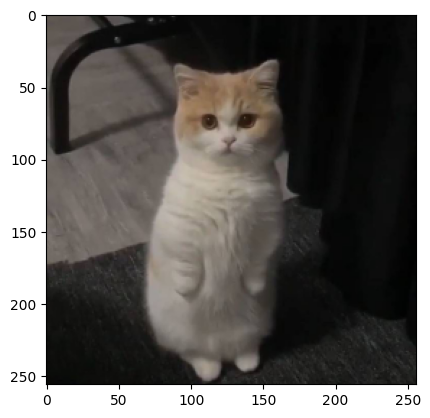

In [28]:
#Drop image url 
# url = input("Enter your url :")
# img = covturl(url)
# img = cv2.imdecode(img, cv2.IMREAD_COLOR)
# img = cv2.imread("images/test.bmp", cv2.IMREAD_GRAYSCALE)
# img = cv2.imread("images/medium.bmp", cv2.IMREAD_COLOR)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

img = plt.imread("images/medium.bmp")

plt.imshow(img)
# plt.savefig("results/input.png")
plt.show()

In [29]:
#Data preprocessing : convert img to binary
shape = img.shape[0]*img.shape[1]*img.shape[2]
imgx = img
img_reshape = img.reshape(shape)
img_binary = []
for i in img_reshape:
    img_binary.append("{0:b}".format(i).zfill(8))    
len(img_binary)    

196608

In [30]:
#CRC adder with key "1101
key = "1101"
img_en = []
for i in img_binary:
    img_en.append(encodeData(i, key))

In [32]:
#transmit image
img_en = np.array(img_en)
img_for_trans1 = []
img_ready_for_trans = []

for i in img_en:
    img_for_trans1.append(split(i))
img_for_trans1 = np.vstack(img_for_trans1)

for i in img_for_trans1:
    for j in range(11):
        img_ready_for_trans.append(int(i[j]))
        
img_ready_for_trans = np.array(img_ready_for_trans)
img_rft = img_ready_for_trans
len(img_rft)

2162688

### Channel Part

[  0  16  32  48  64  80  96 112]
allCarriers:   [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127]
pilotCarriers: [  0  16  32  48  64  80  96 112 127]
dataCarriers:  [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  65  66  67  68  69  70  71  72  73  74  75  76
  77  78  79  81  82  83  84  85  86  87  88  89  90  91  92  93  94  

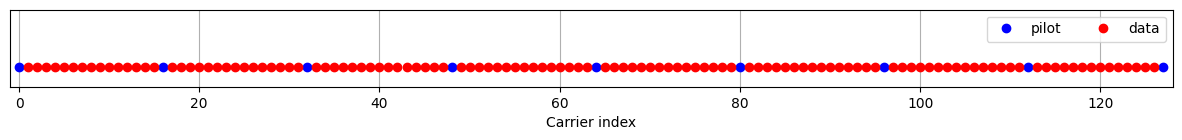

In [33]:
# CHANNEL SETTING

#CA
K = 128
CP = K // 4
P = 8                       # number of pilot carriers per OFDM block
pilotValue = 7+7j           # The known value each pilot transmits
allCarriers = np.arange(K)  # indices of all subcarriers ([0, 1, ... K-1])
pilotCarriers = allCarriers[::K//P]        # Pilots is every (K/P)th carrier.
print(pilotCarriers)

# For convenience of channel estimation, let's make the last carriers also be a pilot
pilotCarriers = np.hstack([pilotCarriers, np.array([allCarriers[-1]])])
P = P+1

# data carriers are all remaining carriers
dataCarriers = np.delete(allCarriers, pilotCarriers)
print ("allCarriers:   %s" % allCarriers)
print ("pilotCarriers: %s" % pilotCarriers)
print ("dataCarriers:  %s" % dataCarriers)
plt.figure(figsize=(15,1))
plt.xlim((-1,K)); plt.ylim((-0.1, 0.3))
plt.xlabel('Carrier index')
plt.yticks([])
plt.grid(True)
plt.plot(pilotCarriers, np.zeros_like(pilotCarriers), 'bo', label='pilot')
plt.plot(dataCarriers, np.zeros_like(dataCarriers), 'ro', label='data')
plt.legend(fontsize=10, ncol=2)

Text(0, 0.5, 'Imaginary part (Q)')

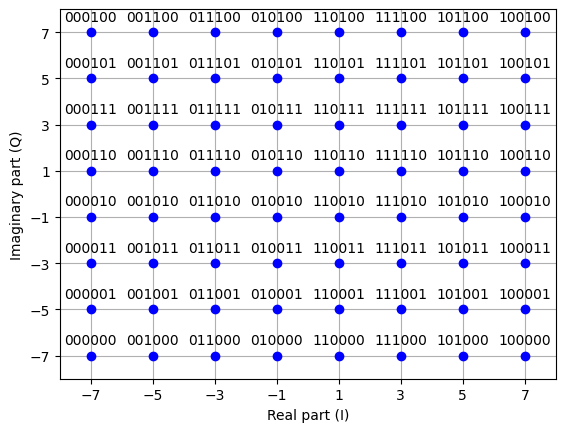

In [35]:
mu = 6 # bits per symbol (64QAM)
payloadBits_per_OFDM = len(dataCarriers)*mu # number of payload bits per OFDM symbol

mapping_table = {
    (0,0,0,0,0,0) : -7-7j,
    (0,0,0,0,0,1) : -7-5j,
    (0,0,0,0,1,1) : -7-3j,
    (0,0,0,0,1,0) : -7-1j,
    (0,0,0,1,1,0) : -7+1j,
    (0,0,0,1,1,1) : -7+3j,
    (0,0,0,1,0,1) : -7+5j,
    (0,0,0,1,0,0) : -7+7j,
    (0,0,1,1,0,0) : -5+7j,
    (0,0,1,1,0,1) : -5+5j,
    (0,0,1,1,1,1) : -5+3j,
    (0,0,1,1,1,0) : -5+1j,
    (0,0,1,0,1,0) : -5-1j,
    (0,0,1,0,1,1) : -5-3j,
    (0,0,1,0,0,1) : -5-5j,
    (0,0,1,0,0,0) : -5-7j,
    (0,1,1,0,0,0) : -3-7j,
    (0,1,1,0,0,1) : -3-5j,
    (0,1,1,0,1,1) : -3-3j,
    (0,1,1,0,1,0) : -3-1j,
    (0,1,1,1,1,0) : -3+1j,
    (0,1,1,1,1,1) : -3+3j,
    (0,1,1,1,0,1) : -3+5j,
    (0,1,1,1,0,0) : -3+7j,
    (0,1,0,1,0,0) : -1+7j,
    (0,1,0,1,0,1) : -1+5j,
    (0,1,0,1,1,1) : -1+3j,
    (0,1,0,1,1,0) : -1+1j,
    (0,1,0,0,1,0) : -1-1j,
    (0,1,0,0,1,1) : -1-3j,
    (0,1,0,0,0,1) : -1-5j,
    (0,1,0,0,0,0) : -1-7j,
    (1,1,0,0,0,0) : 1-7j,
    (1,1,0,0,0,1) : 1-5j,
    (1,1,0,0,1,1) : 1-3j,
    (1,1,0,0,1,0) : 1-1j,
    (1,1,0,1,1,0) : 1+1j,
    (1,1,0,1,1,1) : 1+3j,
    (1,1,0,1,0,1) : 1+5j,
    (1,1,0,1,0,0) : 1+7j,
    (1,1,1,1,0,0) : 3+7j,
    (1,1,1,1,0,1) : 3+5j,
    (1,1,1,1,1,1) : 3+3j,
    (1,1,1,1,1,0) : 3+1j,
    (1,1,1,0,1,0) : 3-1j,
    (1,1,1,0,1,1) : 3-3j,
    (1,1,1,0,0,1) : 3-5j,
    (1,1,1,0,0,0) : 3-7j,
    (1,0,1,0,0,0) : 5-7j,
    (1,0,1,0,0,1) : 5-5j,
    (1,0,1,0,1,1) : 5-3j,
    (1,0,1,0,1,0) : 5-1j,
    (1,0,1,1,1,0) : 5+1j,
    (1,0,1,1,1,1) : 5+3j,
    (1,0,1,1,0,1) : 5+5j,
    (1,0,1,1,0,0) : 5+7j,
    (1,0,0,1,0,0) : 7+7j,
    (1,0,0,1,0,1) : 7+5j,
    (1,0,0,1,1,1) : 7+3j,
    (1,0,0,1,1,0) : 7+1j,
    (1,0,0,0,1,0) : 7-1j,
    (1,0,0,0,1,1) : 7-3j,
    (1,0,0,0,0,1) : 7-5j,
    (1,0,0,0,0,0) : 7-7j,
}
for d5 in [0,1]:
    for d4 in [0,1]:
        for d3 in [0,1]:
            for d2 in [0,1]:
                for d1 in [0,1]:
                    for d0 in [0,1]:
                        D = (d5,d4,d3,d2,d1,d0)
                        Q = mapping_table[D]
                        plt.plot(Q.real,Q.imag, 'bo')
                        plt.text(Q.real,Q.imag+0.5, "".join(str(x) for x in D), ha = 'center')

# plt.title("Mapping Table 6 symbol")
plt.grid(True)
plt.xticks(range(-7,8,2))
plt.yticks(range(-7,8,2))
plt.xlim((-8, 8)); plt.ylim((-8,8)); plt.xlabel('Real part (I)'); plt.ylabel('Imaginary part (Q)')                        
# plt.savefig("results/mapping.png")

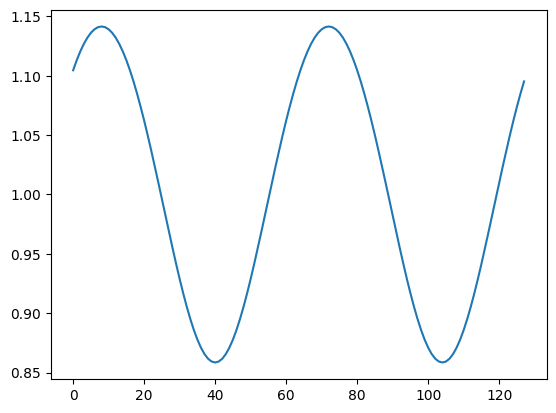

In [36]:
bitx = group_bits(img_rft, payloadBits_per_OFDM)
## in this part, we demonstate selecting only 1 frame to send. ##

demapping_table = {v : k for k, v in mapping_table.items()}
channelResponse = np.array([1,0,0.1+0.1j]) # the impulse response of the wireless channel
H_exact = np.fft.fft(channelResponse, K)
plt.plot(allCarriers, abs(H_exact))
# plt.savefig("results/oneframe.png")

In [37]:
SNRdb = 20# signal to noise-ratio in dB at the receiver
#S/P
bits = np.array(bitx[2]) #we select frame 2 to send
bits_SP = SP(bits, dataCarriers, mu)
print ("First 5 bit groups")
print (bits_SP[:5,:])
print("\n")

First 5 bit groups
[[0 1 0 1 0 1]
 [0 1 0 1 0 1]
 [1 0 1 0 1 0]
 [1 0 1 0 1 1]
 [0 1 0 1 1 1]]




In [ ]:
QAM = Mapping(bits_SP, mapping_table)
print ("First 5 QAM symbols and bits:")
print (bits_SP[:5,:])
print (QAM[:5])

In [ ]:
OFDM_data = OFDM_symbol(QAM, K, pilotCarriers, dataCarriers, pilotValue)
OFDM_time = IDFT(OFDM_data)
OFDM_withCP = addCP(OFDM_time, CP)

print("Number of OFDM carriers in frequency domain: ", len(OFDM_data))
print("Number of OFDM samples in time-domain before CP: ", len(OFDM_time))
print("Number of OFDM samples in time domain with CP: ", len(OFDM_withCP))

In [ ]:
OFDM_TX = OFDM_withCP
OFDM_RX = channel(OFDM_TX, channelResponse, SNRdb)

plt.figure(figsize=(8,2))
plt.plot(abs(OFDM_TX), label='TX signal')
plt.plot(abs(OFDM_RX), label='RX signal')
plt.legend(fontsize=10)
plt.xlabel("Time") 
plt.ylabel("|x(t)|")
plt.grid(True)

plt.savefig("results/tx_rx.png")


In [ ]:
OFDM_RX_noCP = removeCP(OFDM_RX, CP, K)
OFDM_demod = DFT(OFDM_RX_noCP)
print("\n")
Hest = channelEstimate(OFDM_demod, pilotCarriers, pilotValue, allCarriers, H_exact)
equalized_Hest = equalize(OFDM_demod, Hest)
QAM_est = get_payload(equalized_Hest, dataCarriers)
plt.plot(QAM_est.real, QAM_est.imag, 'bo', scalex = True, scaley = True)

In [ ]:
PS_est, hardDecision = Demapping(QAM_est, demapping_table)
for qam, hard in zip(QAM_est, hardDecision):
    plt.plot([qam.real, hard.real], [qam.imag, hard.imag], 'b-o')
    plt.plot(hardDecision.real, hardDecision.imag, 'ro')

In [ ]:
bits_est = PS(PS_est)
print ("Obtained Bit error rate: ", np.sum(abs(bits-bits_est))/len(bits))

In [ ]:
SNR_fp, ber_fp = SNR_return(50, channelResponse, dataCarriers, mu, bitx, CP, K, mapping_table)
plt.plot(SNR_fp, ber_fp)
plt.xlabel("SNR(E0/N0)")
plt.ylabel("Bit error rate(%)")
plt.grid(True)
plt.savefig("results/ber.png")
plt.show()

In [ ]:
ysmoothed = gaussian_filter1d(ber_fp, sigma=15)
plt.plot(SNR_fp, ysmoothed, 'c')
plt.xlabel("SNR(E0/N0)")
plt.ylabel("Bit error rate(%)")
plt.grid(True)
plt.show()

In [ ]:
## The expression of wave in time domain & frequency domain
bit_plot(2, 1, 3)

### Receiver Part

In [ ]:
SNR = 1 #Change to adjust channel quaility
bit_rx = pro_bits(SNR, bitx)

bit_rx = np.array(bit_rx)
img_fr = []
img_rfr = []
for i in bit_rx:
  img_fr.append(split(i))
img_fr = np.vstack(img_fr)

img_rfr = []
for i in img_fr:
    for j in range(len(img_fr[:2][1])):
        img_rfr.append(int(i[j]))
img_rfr = np.array(img_rfr)

img_rfr1 = []
for i in range(len(img_rft)):
    x = img_rfr[i]
    img_rfr1.append(x)
img_rfr1 = np.array(img_rfr1)

img_rea = []
k = 0
for i in range(len(img_rfr1)):
    img_rea.append(img_rfr1[k:k+11])
    k+=11
    
img_done = []
for i in img_rea[:]:
    x = []
    for j in range(len(i)):
        x.append(str(i[j]))
    img_done.append(x)

sep = ''
img_fin = []
for i in img_done:
    img_fin.append(sep.join(i))

In [ ]:
#remove CRC and compare
img_crc = []
for i in img_fin:
    img_crc.append(decodeData(i, key))

count = 0
for i in img_crc:
    if i != '000':
        if i!= '00':
            count += 1

print("Amount of total bits: %10d" %(len(img_rft)))
print("Amount of error bit(s): %4d" %count)

In [ ]:
#decode
img_dec = []
for i in img_fin:
    img_dec.append(i[0:8])
img_dec = np.array(img_dec)


In [ ]:
##We can change SNR to see another quality of the image after passing the channel 
img_back = []
for i in range(len(img_binary)):
    img_back.append(int(img_dec[i],2))
img_back = np.array(img_back)
img_back = img_back.reshape(imgx.shape[0], imgx.shape[1], imgx.shape[2])
plt.imshow(img_back)